### Tasks To be Performed:
1. Transform the Text data to be processed for Sentiment Analysis
2. Generate Sentiments for unlabeled news headlines data.
3. Evaluate the sentiment analysis models based on accuracy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import string


from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data = pd.read_csv('twitter_training.csv',names=['id','Brand','Sentiment','Phrase'])

In [3]:
data.head(5)

,id,Brand,Sentiment,Phrase
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   Brand      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Phrase     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
data.isnull().sum().sum()/data.shape[0] * 100

0.9185613668621622

In [6]:
data.loc[data.Phrase.isnull()]

,id,Brand,Sentiment,Phrase
61,2411,Borderlands,Neutral,NaN
553,2496,Borderlands,Neutral,NaN
589,2503,Borderlands,Neutral,NaN
745,2532,Borderlands,Positive,NaN
1105,2595,Borderlands,Positive,NaN
...,...,...,...,...
73972,9073,Nvidia,Positive,NaN
73973,9073,Nvidia,Positive,NaN
74421,9154,Nvidia,Positive,NaN
74422,9154,Nvidia,Positive,NaN


In [7]:
data = data.dropna(axis=0)

In [8]:
data.shape

(73996, 4)

# Count of Feedbacks per brand

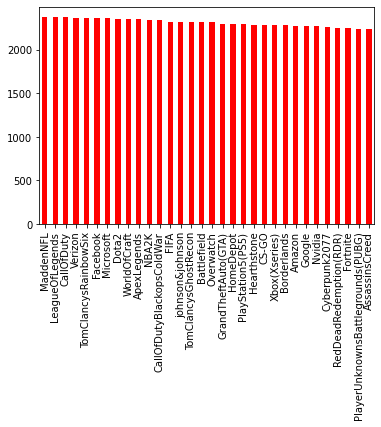

In [9]:
data.Brand.value_counts().plot(kind='bar',color='red')

# Distribution of Sentiment 

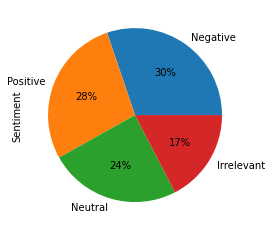

In [10]:
data.Sentiment.value_counts().plot(kind='pie',autopct='%1.0f%%')
plt.show()

# Distribution of Sentiments across all the Brands

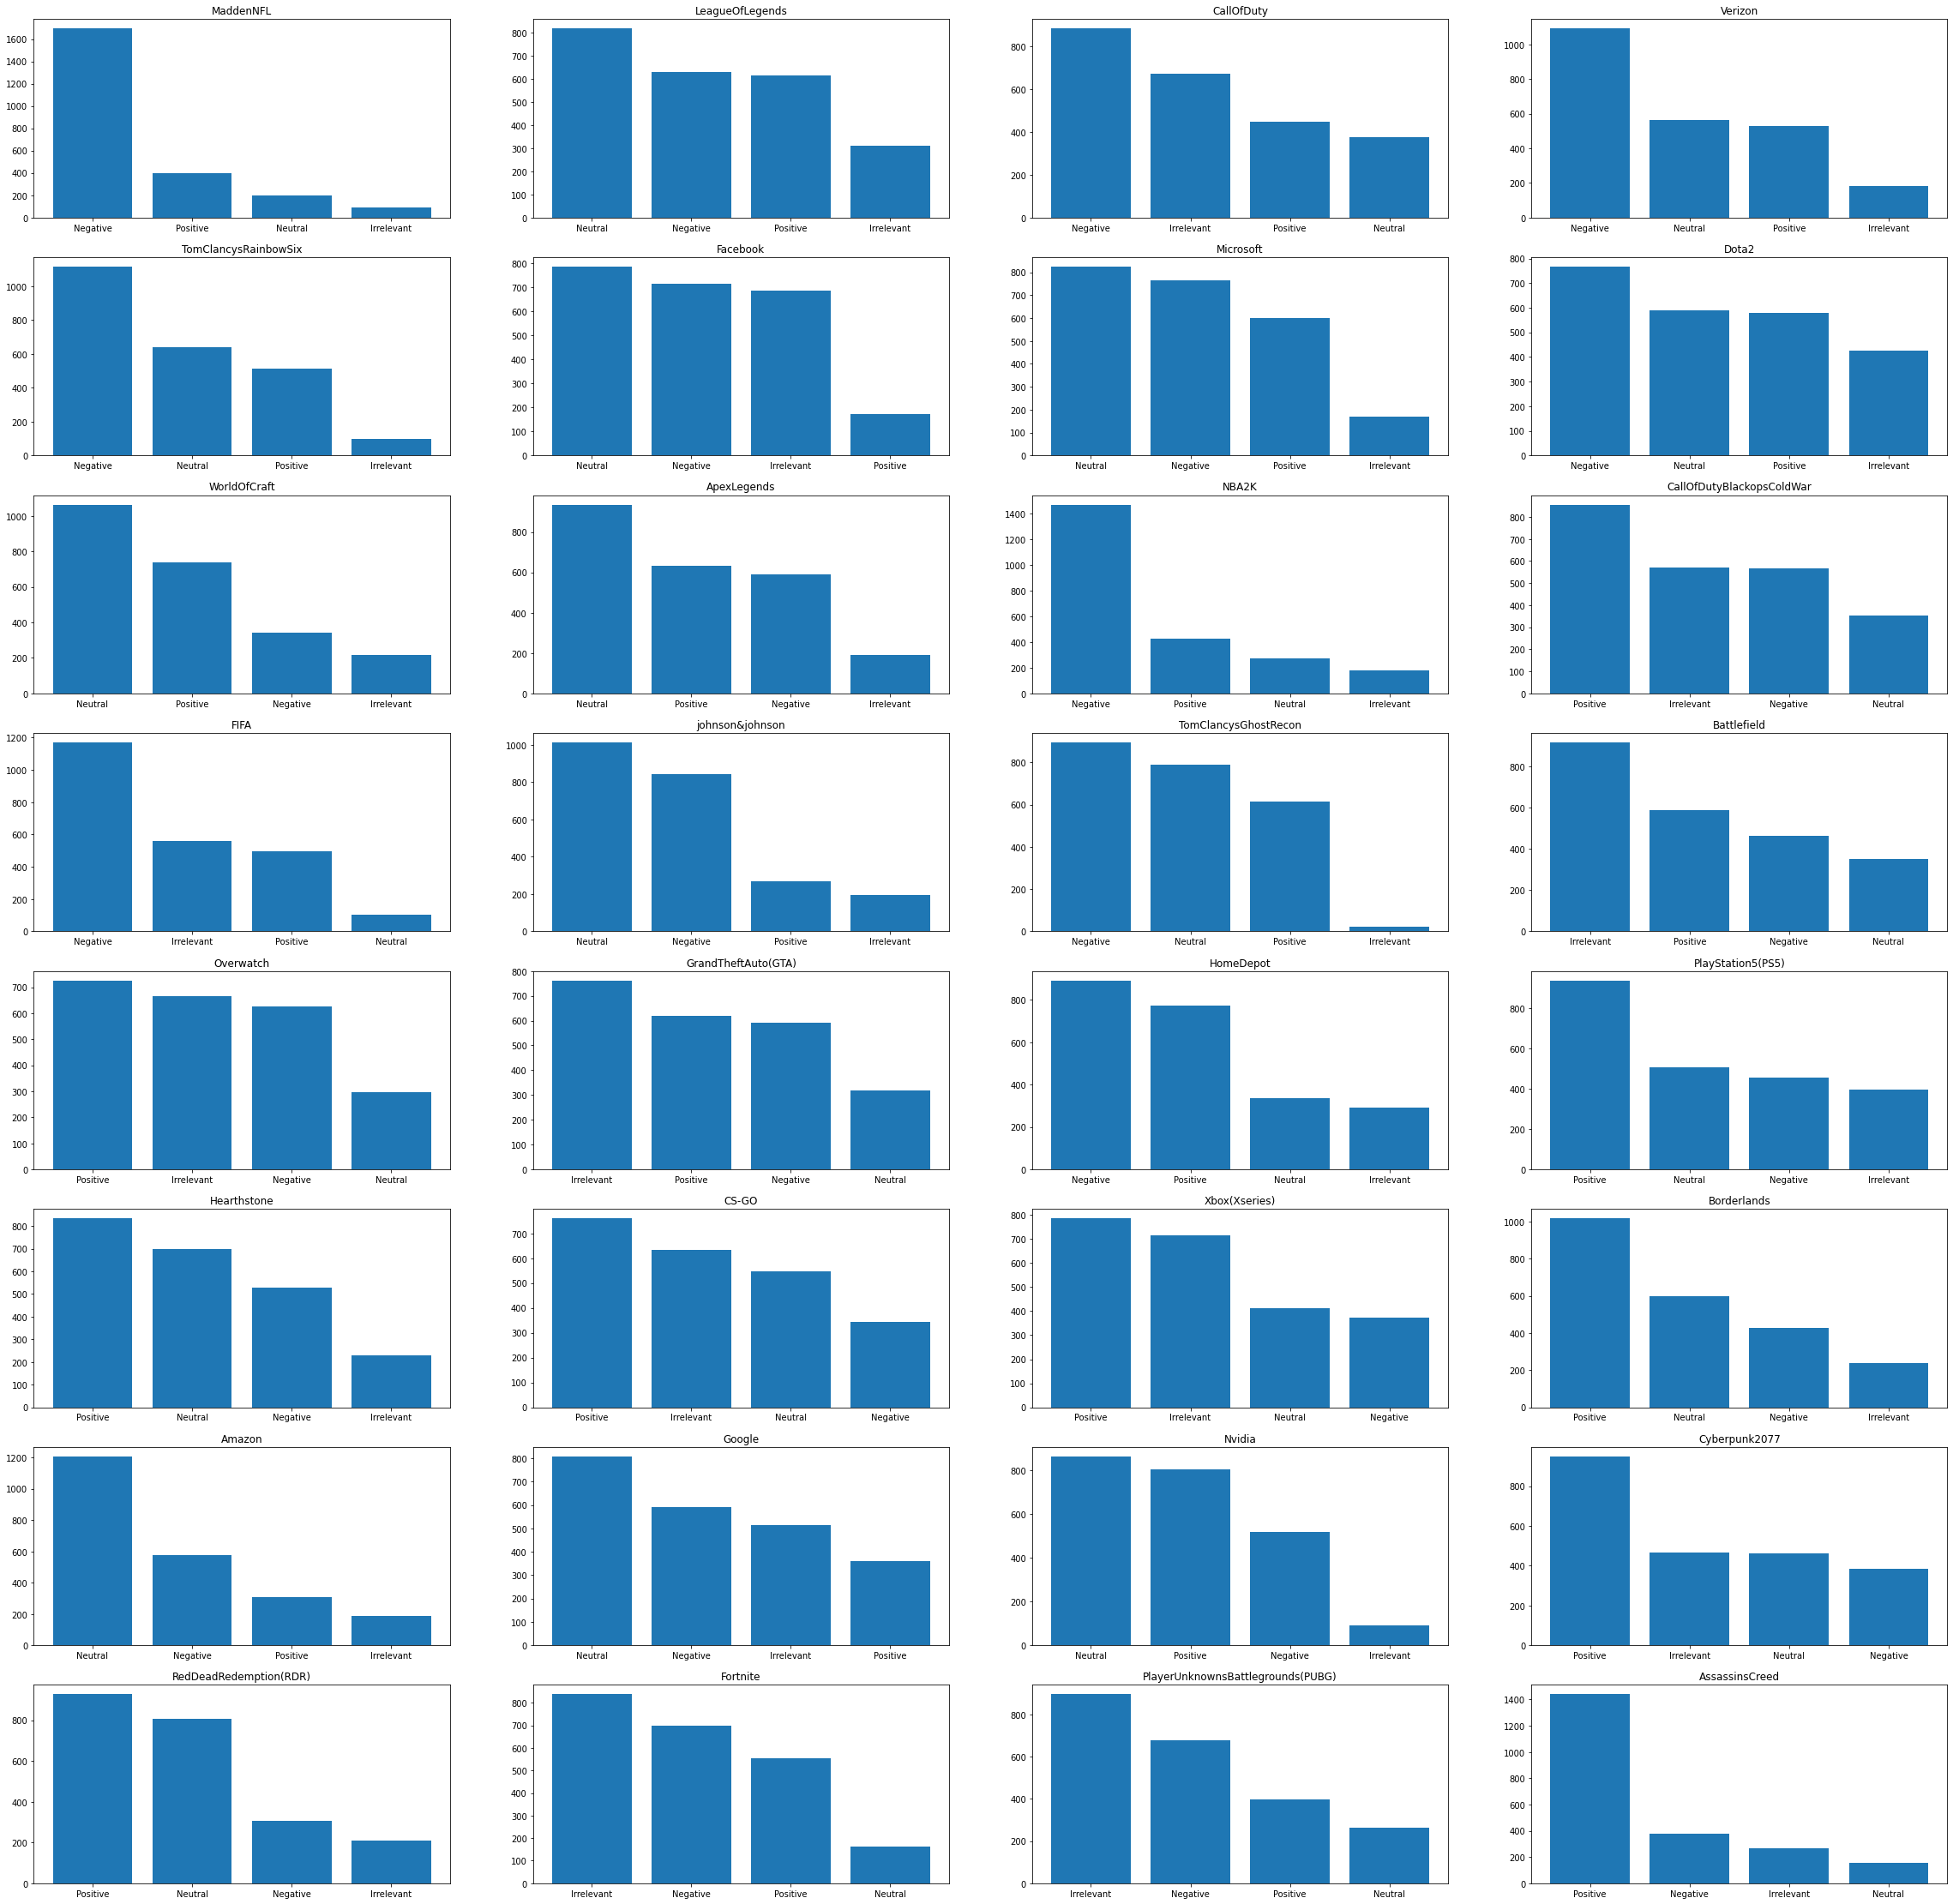

In [11]:
sub = 1
plt.subplots(8,4,figsize=(40,40))
for brand in data.Brand.value_counts().index:
    dt = data.loc[data['Brand'] == brand,'Sentiment'].value_counts()
    plt.subplot(8,4,sub)
    plt.title(brand)
    plt.bar(x=dt.index,height=dt.values)
    sub += 1

# Lowercase all the text

In [12]:
text = data.Phrase[0]
text

'im getting on borderlands and i will murder you all ,'

In [13]:
text.lower()

'im getting on borderlands and i will murder you all ,'

# Removing Punctuation

In [14]:
text = "".join([letter for letter in text if letter not in string.punctuation])
text

'im getting on borderlands and i will murder you all '

# Tokenizing the text

In [15]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
text = word_tokenize(text)
text

['im',
 'getting',
 'on',
 'borderlands',
 'and',
 'i',
 'will',
 'murder',
 'you',
 'all']

# Removing Stop Words

In [17]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
stop_words = set(stopwords.words('english'))
text = [word for word in text if word not in stop_words]

In [19]:
text

['im', 'getting', 'borderlands', 'murder']

# Stemming

In [20]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [21]:
text = [stemmer.stem(word) for word in text]
text

['im', 'get', 'borderland', 'murder']

# Creating a function to perform all the above steps on all the feedbacks

In [22]:
import re
texts = data.Phrase.values.tolist()

In [23]:
def text_processing(text):
  # Lower case
  text = text.lower()
  
  # Tokenization
  text = word_tokenize(text)
  
  # Cleaning Up mentions, hashtags and links 
  text = [re.sub(r'\@\w*','',word) for word in text]
  text = [re.sub(r'\#','',word) for word in text]
  text = [re.sub(r'pic.*','',word) for word in text]
  
  # Removing Punctuation
  text = [letter for letter in text if letter not in string.punctuation]
  
  # Removing Stop Words
  stop_words = set(stopwords.words('english'))
  text = [word for word in text if word not in stop_words]

  # Stemming
  stemmer = PorterStemmer()
  text = [stemmer.stem(word) for word in text]

  return text



In [24]:
texts = [text_processing(text) for text in texts]

In [25]:
texts[:5]

[['im', 'get', 'borderland', 'murder'],
 ['come', 'border', 'kill'],
 ['im', 'get', 'borderland', 'kill'],
 ['im', 'come', 'borderland', 'murder'],
 ['im', 'get', 'borderland', '2', 'murder']]

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
max_words = 20000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)

In [75]:
from sklearn.model_selection import train_test_split
sentiments = data.Sentiment.values
y = pd.get_dummies(sentiments)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.3, random_state = 3)

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


In [77]:
model = Sequential()
model.add(Embedding(max_words,64,input_length = max_len))
model.add(LSTM(64,return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(4,activation = 'softmax'))

In [78]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 64)           1280000   
                                                                 
 lstm_11 (LSTM)              (None, 100, 64)           33024     
                                                                 
 dropout_11 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_12 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1,346,308
Trainable params: 1,346,308
No

In [79]:
model.compile(optimizer = Adam(0.0001),
              metrics = 'accuracy',
              loss = 'categorical_crossentropy')

model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 15 , validation_data = (X_val,y_val))

Epoch 1/15
2082/2082 [==============================] - 30s 13ms/step - loss: 1.2139 - accuracy: 0.4425 - val_loss: 0.9658 - val_accuracy: 0.6145
Epoch 2/15
2082/2082 [==============================] - 28s 13ms/step - loss: 0.8351 - accuracy: 0.6743 - val_loss: 0.7378 - val_accuracy: 0.7210
Epoch 3/15
2082/2082 [==============================] - 26s 13ms/step - loss: 0.6410 - accuracy: 0.7573 - val_loss: 0.6464 - val_accuracy: 0.7606
Epoch 4/15
2082/2082 [==============================] - 27s 13ms/step - loss: 0.5302 - accuracy: 0.8031 - val_loss: 0.5643 - val_accuracy: 0.7921
Epoch 5/15
2082/2082 [==============================] - 26s 12ms/step - loss: 0.4553 - accuracy: 0.8300 - val_loss: 0.5278 - val_accuracy: 0.8046
Epoch 6/15
2082/2082 [==============================] - 26s 13ms/step - loss: 0.4080 - accuracy: 0.8493 - val_loss: 0.5026 - val_accuracy: 0.8230
Epoch 7/15
2082/2082 [==============================] - 26s 12ms/step - loss: 0.3675 - accuracy: 0.8637 - val_loss: 0.4848 -

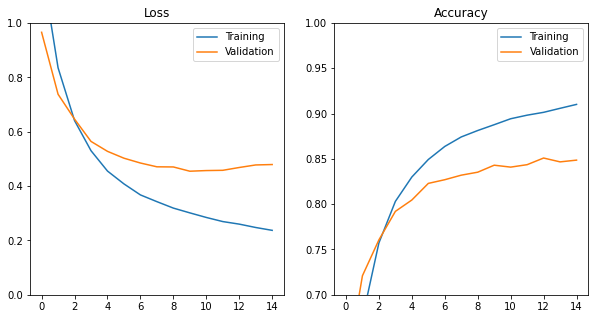

In [80]:
hist = model.history.history

fig = plt.subplots(1,2,figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(hist["loss"])
plt.plot(hist['val_loss'])
plt.legend(['Training','Validation'])
plt.ylim(0,1)
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(hist["accuracy"])
plt.plot(hist['val_accuracy'])
plt.legend(['Training','Validation'])
plt.ylim(0.7,1)
plt.title('Accuracy')
plt.show()

In [81]:
model.evaluate(X_val,y_val)

162/162 [==============================] - 1s 6ms/step - loss: 0.4793 - accuracy: 0.8486


[0.4792538583278656, 0.8486486673355103]

#Generating Sentiments for Unlabelled Headlines


In [106]:
headlines = pd.read_csv('fakereal.csv')

In [107]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    256 non-null    object
 1   label   256 non-null    object
dtypes: object(2)
memory usage: 4.1+ KB


In [108]:
headlines.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [84]:
headlines.isnull().sum()

text     0
label    0
dtype: int64

In [110]:
headline = headlines.text.values.tolist()
headline = [text_processing(header) for header in headline]

In [121]:
sequences2 = tokenizer.texts_to_sequences(headline)
headlines_X = pad_sequences(sequences2, maxlen=max_len)

In [124]:
headlines_X.shape

(256, 100)

In [125]:
y_pred = model.predict(headlines_X)

8/8 [==============================] - 0s 7ms/step


In [126]:
classes = y.columns.tolist()

In [135]:
classes[np.argmax(y_pred[10])]

'Positive'

In [134]:
headlines.text[10]

'CEDAR RAPIDS, Iowa — “I had one of the most wonderful rallies of my entire career right here in 1992,” Bill Clinton said by way of opening to the crowd of more than 1,100 on Saturday night.\n\nTwo days before the Iowa caucuses, Cedar Rapids tried to deliver that same old feeling to his wife, Hillary Clinton.\n\nIn the crowd,\xa0one woman held a sign that said “227 years of men. It’s HER turn!" Some carried signs and books. Others had traveled from as far as Missouri. They had waited hours, even after the fire marshal told them there was no more room inside the high school gymnasium.\n\nThe restive crowd chanted slogans and buzzed with anticipation until finally Bill, Hillary and Chelsea Clinton all appeared on stage hand-in-hand, an hour behind schedule. As they roared, Hillary Clinton beamed.\n\nIt has been a long slog in Iowa for the Clinton campaign, which has struggled mightily to shake the label that its supporters can’t muster the enthusiasm of its rival’s backers. As the caucus

In [138]:
headlines['sentiment'] = y_pred.argmax(axis = 1)

In [142]:
headlines['sentiment'] = headlines.sentiment.map({ 0 : classes[0],
                                                  1 : classes[1],
                                                  2 : classes[2],
                                                  3 : classes[3]})

In [143]:
headlines

,text,label,sentiment
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,Negative
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Irrelevant
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,Neutral
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Neutral
4,It's primary day in New York and front-runners...,REAL,Irrelevant
...,...,...,...
251,"Wed, 26 Oct 2016 18:19 UTC © Jen Psaki Preside...",FAKE,Positive
252,When Donald Trump introduced his new universit...,REAL,Neutral
253,Trump Has Forever Changed American Politics > ...,FAKE,Negative
254,With Western and Iranian negotiators racing to...,REAL,Neutral
